# Program for analysizing ISIMIP3a yields data
## This program is to check if the crop models can regenerate real maize production for the perods

The comparison of simulated production covers the 20-year period from 1996 to 2015, during which the crop models are driven by observed climate data. This comparison involves two distinct approaches. Firstly, it evaluates the 20-year average maize production modeled by each of the 11 individual models and the ensemble mean against the average maize production derived from 3-year SPAM data, assumed to represent the true production over the 20-year period. Secondly, it assesses the production for each of the 3 years individually for each model and the ensemble mean.

In [1]:
import glob
import os
# Ignore warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

#Process data
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#Display data 
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt


## 1. check availability of dataset

Load 2000, 2005 and 2010 SPAM production data. 

In [3]:
spam_production=np.load('average_all.npy')
spam_production=np.where(spam_production <= 0, np.nan, spam_production)

In [4]:
min_lon = -100 
min_lat = 35
max_lon = -70
max_lat = 65
min_time=334  #1995
max_time=353  #2014

In [5]:
Path='/media/Data1/Climada/isimip3/nc4/'
gcms=['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']
ggcms=['acea','crover','cygma1p74','dssat-pythia','epic-iiasa','isam',
       'ldndc','lpjml','pdssat','pepic','promet','simplace-lintul5']

### 1.1 Landuse data in percentages

In [6]:
fn1 = '/media/Data1/Climada/ISIMIP/data/landuse-15crops_2015soc_annual_1850_2014.nc'
ds_landuse=xr.open_dataset(fn1,decode_times=False)
ds1995to2014=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(min_time,max_time))

ds2000=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(339,339))
ds2005=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(344,344))
ds2010=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(349,349))

maize_rainfed_landuse_in_percentage_1995to2014 = ds1995to2014["maize_rainfed"]*100
maize_irrigated_landuse_in_percentage_1995to2014 = ds1995to2014["maize_irrigated"]*100

maize_rainfed_landuse_in_percentage_1995to2014_average = ds1995to2014["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_1995to2014_average = ds1995to2014["maize_irrigated"].mean(dim='time')*100

maize_rainfed_landuse_in_percentage_2000 = ds2000["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_2000 = ds2000["maize_irrigated"].mean(dim='time')*100

maize_rainfed_landuse_in_percentage_2005 = ds2005["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_2005 = ds2005["maize_irrigated"].mean(dim='time')*100

maize_rainfed_landuse_in_percentage_2010 = ds2010["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_2010 = ds2010["maize_irrigated"].mean(dim='time')*100


In [7]:
areainsqmeter=np.load('originalcode/code/ipynb/areainsqmeter_squared_meter_great_lake_region_35N65N.npy')

# combined_landuse=np.load('originalcode/code/ipynb/combined_landuse_35N65N.npy')
# rainfed_landuse=np.load('originalcode/code/ipynb/rainfed_landuse_35N65N.npy')
# irrigated_landuse=np.load('originalcode/code/ipynb/irrigated_landuse_35N65N.npy')


In [8]:
## check content in the data file
file='/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4'
ds=xr.open_dataset(file,decode_times=False)
ds

<xarray.Dataset>
Dimensions:     (lon: 720, lat: 360, years: 37, irr: 2)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years       (years) int32 1979 1980 1981 1982 1983 ... 2012 2013 2014 2015
  * irr         (irr) float64 1.0 2.0
Data variables:
    yield       (irr, years, lat, lon) float64 ...
    production  (irr, years, lat, lon) float64 ...

In [9]:
#check if all data are available
fns=glob.glob("/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_*default_annual_mai_yield_and_production.nc4")
len(fns)


11

In [10]:
fns

['/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3

## 2. Below is an example to display what information in the data file

### 2.1 Check data from GGCMI

In [11]:

fn='/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_acea_gswp3-w5e5_default_annual_mai_yield_and_production.nc4'
ds=xr.open_dataset(fn,decode_times=False)
ds

<xarray.Dataset>
Dimensions:     (lon: 720, lat: 360, years: 37, irr: 2)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years       (years) int32 1979 1980 1981 1982 1983 ... 2012 2013 2014 2015
  * irr         (irr) float64 1.0 2.0
Data variables:
    yield       (irr, years, lat, lon) float64 ...
    production  (irr, years, lat, lon) float64 ...

In [12]:
cropped_ds00 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2015','2015'), irr=1.0)
cropped_ds01 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2015','2015'), irr=2.0)
cropped_ds00  

<xarray.Dataset>
Dimensions:     (lon: 60, lat: 60, years: 1)
Coordinates:
  * lon         (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat         (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * years       (years) int32 2015
    irr         float64 1.0
Data variables:
    yield       (years, lat, lon) float64 ...
    production  (years, lat, lon) float64 ...

In [13]:
cropped_ds00['yield'].values.squeeze()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [14]:
cropped_ds01

<xarray.Dataset>
Dimensions:     (lon: 60, lat: 60, years: 1)
Coordinates:
  * lon         (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat         (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * years       (years) int32 2015
    irr         float64 2.0
Data variables:
    yield       (years, lat, lon) float64 ...
    production  (years, lat, lon) float64 ...

### 2.2 Check data from isimip3

In [15]:
file='/media/Data1/Climada/isimip3/maize3a/acea_gswp3-w5e5_obsclim_2015soc_default_yield-mai-noirr_global_annual-gs_1901_2016.nc'
ds2=xr.open_dataset(file,decode_times=False)
cropped_ds10 = ds2.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(114,114.0))
cropped_ds10

<xarray.Dataset>
Dimensions:          (lon: 60, lat: 60, time: 1)
Coordinates:
  * lon              (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat              (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * time             (time) float64 114.0
Data variables:
    yield-mai-noirr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_comment:           Data is taken from GGCMI (AgMIP) Phase 3a and r...
    isimip_id:                cd500114-9319-411d-be9a-47a61978c171
    isimip_protocol_version:  027342a3356372791ca6318f6bd552ee712cfd4a
    isimip_qc_version:        3.0.2
    isimip_qc_pass_date:      2023-07-20 13:43 UTC

In [16]:
file='/media/Data1/Climada/isimip3/maize3a/acea_gswp3-w5e5_obsclim_2015soc_default_yield-mai-firr_global_annual-gs_1901_2016.nc'
ds1=xr.open_dataset(file,decode_times=False)
ds1

<xarray.Dataset>
Dimensions:         (lon: 720, lat: 360, time: 116)
Coordinates:
  * lon             (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat             (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 112.0 113.0 114.0 115.0
Data variables:
    yield-mai-firr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_comment:           Data is taken from GGCMI (AgMIP) Phase 3a and r...
    isimip_id:                b8e236a6-6ac8-4f8a-924f-a621891b1ba5
    isimip_protocol_version:  027342a3356372791ca6318f6bd552ee712cfd4a
    isimip_qc_version:        3.0.2
    isimip_qc_pass_date:      2023-07-20 13:43 UTC

In [17]:
cropped_ds11 = ds1.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(114,114))
cropped_ds11  

<xarray.Dataset>
Dimensions:         (lon: 60, lat: 60, time: 1)
Coordinates:
  * lon             (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat             (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * time            (time) float64 114.0
Data variables:
    yield-mai-firr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_comment:           Data is taken from GGCMI (AgMIP) Phase 3a and r...
    isimip_id:                b8e236a6-6ac8-4f8a-924f-a621891b1ba5
    isimip_protocol_version:  027342a3356372791ca6318f6bd552ee712cfd4a
    isimip_qc_version:        3.0.2
    isimip_qc_pass_date:      2023-07-20 13:43 UTC

### 2. 3 Compare data from GGCMI and ISIMIP3

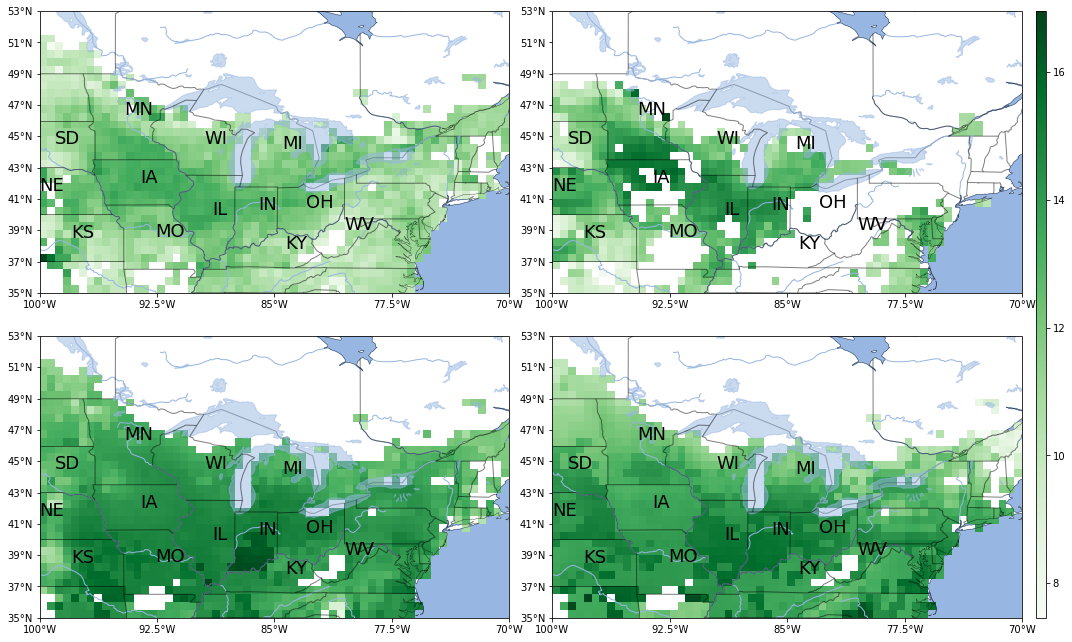

In [18]:
provinces= ['Ontario', 'Quebec','Manitoba','Wisconsin','Vermont','Nebraska','New York','Kansas','Illinois',
            'Delaware','Connecticut','Indiana','Missouri','Michigan','New Jersey','Kentucky','Minnesota',
            'Ohio','Iowa','Pennsylvania','Maryland','Virginia','West Virginia','North Dakota','South Dakota','Nunavut']
provinces1=['ON','QC','MB','WI','VT','NE','NY','KS','IL','DE','CT','IN','MO','MI','NJ','KY','MN','OH','IA','PA','MD','VA','WV','ND','SD','NU']
Latitudes= [50,53,56.4,44.5,44,41.5,43,38.5,40,39,41.6,40.3,38.6,44.2,39.8,37.8,46.4,
            40.4,42,41.2,39,38,39,47.7,44.5,62]
Longitudes=[-85,-76,-98.7,-89.5,-72,-100,-75,-98,-89,-73.5,-72.7,-86,-92.6,-84.5,-74.9,-84.3,-94.6,
            -83,-93.6,-77.2,-76.6,-78,-80.5,-99,-99,-98]

mask=np.load('/media/Data1/Climada/isimip3/reference/isimip3b_mask60X60.npy')

lats = cropped_ds11.coords['lat'][:]
lons = cropped_ds11.coords['lon'][:]
X,Y = np.meshgrid(lons,lats)
projection = ccrs.PlateCarree()
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')
axes_class = (GeoAxes,
              dict(map_projection=projection))
# lons, lats = np.meshgrid(lons, lats)
title_text=["Refereance", "2050s", "2080s"]
fig = plt.figure(figsize=(15,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1%',
                label_mode='')  # note the empty labe
for i, ax in enumerate(axgr):
#*************************************************************
    if i==0:
        data=cropped_ds00['yield'].values.squeeze()*mask
    if i==1:
        data=cropped_ds01['yield'].values.squeeze()*mask        

    if i==2:
        data=cropped_ds10['yield-mai-noirr'].values.squeeze()*mask 
    if i==3: 
        data=cropped_ds11['yield-mai-firr'].values.squeeze()*mask       
                     
#add ocean, coastline,borders,lakes,rivers,provinc_bodr
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(provinc_bodr, linestyle='-', linewidth=1, edgecolor="k", zorder=10, alpha=0.5)
    #ax.set_title(subtitle, fontsize=30)
    ax.set_xlim([-100,-70])
    ax.set_ylim([35,53])
    ax.set_xticks(np.linspace(-100, -70, 5), crs=projection)
    ax.set_yticks(np.linspace(35, 53, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
#     p = ax.contourf(lons, lats, data,50,
#                         transform=projection,
#                         cmap='BrBG')
    
#     l = ax.contour(lons, lats, data,25,colors=['black'], linewidth=0.3,
#                         transform=ccrs.PlateCarree())
    for iprov in range(26):
        if Longitudes[iprov]<-80 and Latitudes[iprov]<47:
            ax.text(Longitudes[iprov],Latitudes[iprov],provinces1[iprov],fontsize=18)
#     p = ax.pcolormesh(X, Y, data,
#                       vmin=-300,
#                       vmax=300,
#                       transform=projection,
#                       cmap='Reds')
    p = ax.pcolormesh(X, Y, data,
                      transform=projection,
#                       vmin=100000,
#                       vmax=1500000,
                      cmap='Greens')    
#     ax.clabel(
#         l,  # Typically best results when labelling line contours.
#         colors=['black'],
#         manual=False,  # Automatic placement vs manual placement.
#         inline=True,  # Cut the line where the label will be placed.
#         fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
#     )
axgr.cbar_axes[0].colorbar(p)
plt.tight_layout()
plt.show()

In [19]:
np.nanmax(data)

16.950000762939453

## 3. Check the ratio of production from model against the production from SPAM data


### 3.1 Comparison of 20-year averages

In [20]:
name_ggcms=['(a) simplace-lintul5','(b) cygma1p74','(c) pepic','(d) epic-iiasa','(e) crover','(f)pdssat',
       '(g) isam','(h) lpjml','(i) ldndc','(j) promet','(k) acea','(l) Ensemble']

#### 3.1.1 Calculate annual production

In [21]:
# calculated in 1.1
# maize_rainfed_landuse_in_percentage_1995to2014 = ds1995to2014["maize_rainfed"]*100
# maize_irrigated_landuse_in_percentage_1995to2014 = ds1995to2014["maize_irrigated"]*100
maize_rainfed_landuse_in_percentage_1995to2014.shape

(20, 60, 60)

In [22]:
np.nanmax(maize_rainfed_landuse_in_percentage_1995to2014)

38.70056

In [23]:
np.nanmin(maize_rainfed_landuse_in_percentage_1995to2014)

0.0

In [24]:
# 11 models, 20 years
production_1995to2014=np.empty(shape=(11,20,60,60))
production_1995to2014_rainfed=np.empty(shape=(11,20,60,60))
production_1995to2014_irrigated=np.empty(shape=(11,20,60,60))
ii=0
for fn in fns:
    print(fn)
    ds=xr.open_dataset(fn,decode_times=False)
    jj=0
    for iyear in range(1995,2015,1):
        try:
            cyear=str(iyear)
            # each year landuse data
            rainfed_landuse=maize_rainfed_landuse_in_percentage_1995to2014[jj,:,:]
            irrigated_landuse=maize_irrigated_landuse_in_percentage_1995to2014[jj,:,:]
            # each land use data
            cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice(cyear,cyear), irr=1.0).fillna(0)
            cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice(cyear,cyear), irr=2.0).fillna(0)

            #average over years and sum over irrigated and rainfed
            crop_isimip3a1_mean=cropped_ds1['yield'].values.squeeze()*(rainfed_landuse/100)*(areainsqmeter/10000)
            production_1995to2014_rainfed[ii,jj,:,:]=crop_isimip3a1_mean

            crop_isimip3a2_mean=cropped_ds2['yield'].values.squeeze()*(irrigated_landuse/100)*(areainsqmeter/10000)
            production_1995to2014_irrigated[ii,jj,:,:]= crop_isimip3a2_mean
        except Exception as e:
            print([ii,jj],fn)
        
        jj=jj+1
    ii=ii+1

/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_ldndc_gswp3-w5e5_default_annual_

In [25]:
production_1995to2014_rainfed=np.where(np.isnan(production_1995to2014_rainfed),0, production_1995to2014_rainfed)
production_1995to2014_irrigated=np.where(np.isnan(production_1995to2014_irrigated),0,production_1995to2014_irrigated)
production_1995to2014=production_1995to2014_rainfed+production_1995to2014_irrigated                                                                                          

In [26]:
mean_production=np.nanmean(production_1995to2014,axis=1)

In [27]:
mean_production.shape

(11, 60, 60)

In [28]:
ensembleMean=np.nanmean(mean_production,axis=0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 1.706e+04
Date:                Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:02:27   Log-Likelihood:                -14732.
No. Observations:                1178   AIC:                         2.947e+04
Df Residuals:                    1176   BIC:                         2.948e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.936e+04   2349.687     12.494      0.0

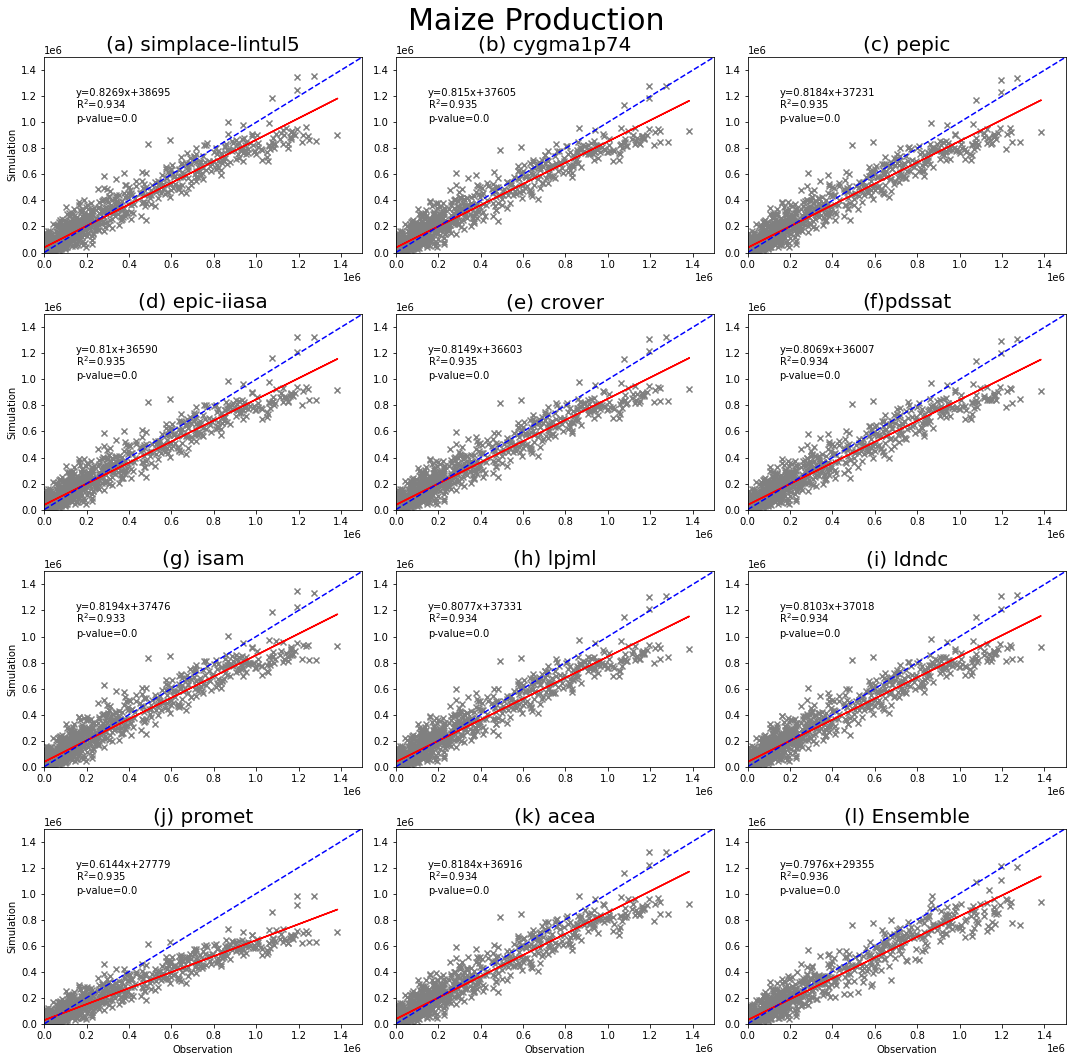

In [57]:
production_1996to2015=np.empty(shape=(13,60,60)) # 1-11: 11 models; 12: ensemble mean;13:spam data

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
ii=0

for ii in range(11):

    data=mean_production[ii,:,:].squeeze()

        
    X = spam_production.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan    
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)
    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()
    # Print the summary
    #print(results.summary())  

    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)

    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_ggcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
production_1996to2015[11,:,:]=ensembleMean
production_1996to2015[12,:,:]=spam_production
data=np.where(ensembleMean == 0, np.nan, ensembleMean)
#/spam_production
X = spam_production.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title(name_ggcms[ii], fontsize=20)
plt.tight_layout()
# ax.set_xlim(0,15)
# ax.set_ylim(0,15) 
#fig.savefig('isimip3a_production_observation_simulation_regression_for_maize.png',dpi=150)
# np.save('isimip3a_1995to2014_production.npy',production_1996to2015)

In [30]:
mean_production.shape

(11, 60, 60)

/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_ldndc_gswp3-w5e5_default_annual_

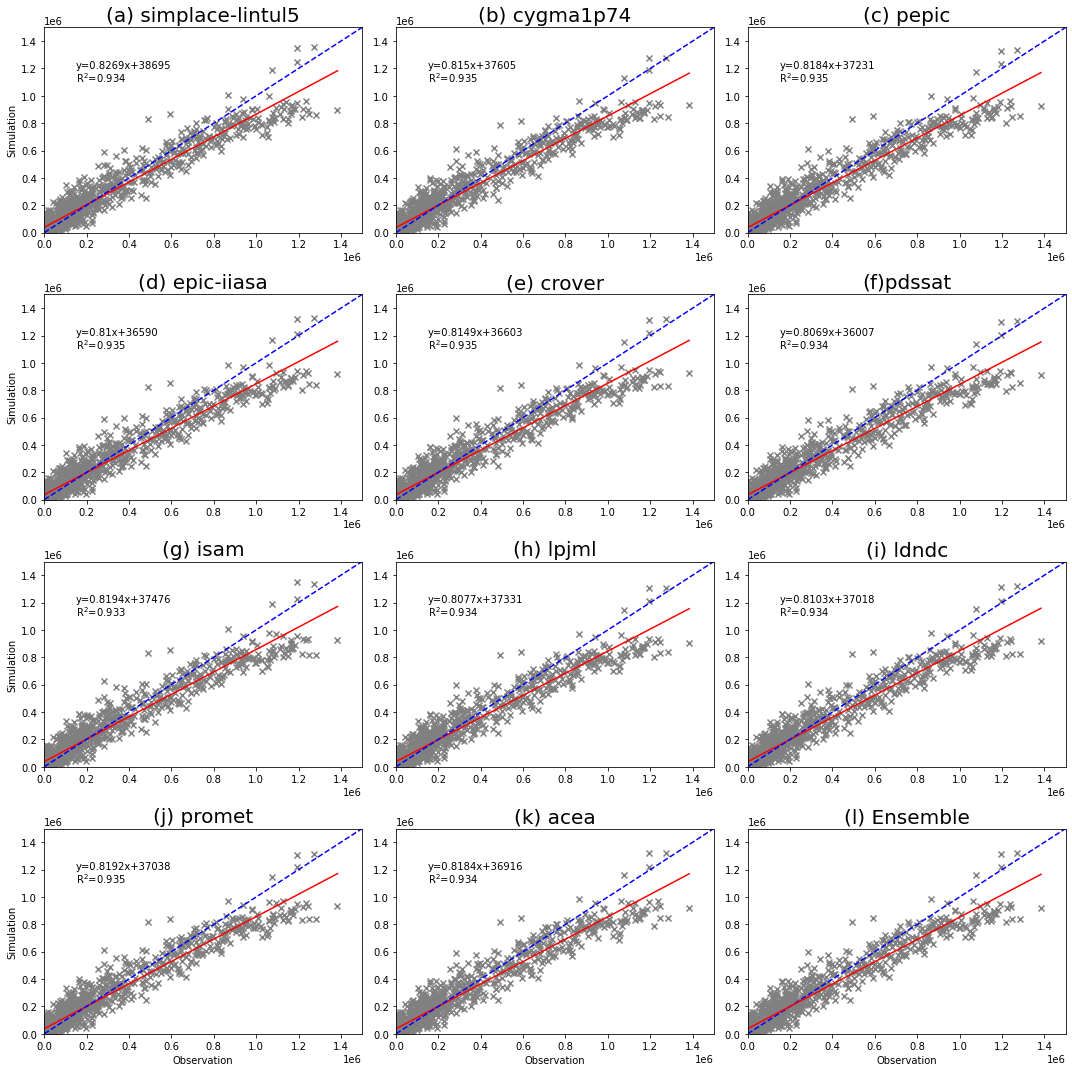

In [61]:
production_1996to2015=np.empty(shape=(13,60,60)) # 1-11: 11 models; 12: ensemble mean;13:spam data

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
ii=0

for fn in fns:
    print(fn)
    ds=xr.open_dataset(fn,decode_times=False)
    #ds=xr.open_dataset(fn)
    #subtract data in space and time, fill nan with 0
    cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=1.0).fillna(0)
    cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=2.0).fillna(0)
  
    #average over years and sum over irrigated and rainfed
    crop_isimip3a1_mean=cropped_ds1.mean(dim='years')*rainfed_landuse/100
    crop_isimip3a2_mean=cropped_ds2.mean(dim='years')*irrigated_landuse/100
    crop_isimip3a_mean= crop_isimip3a1_mean+crop_isimip3a2_mean
#     #these data are change in % relative to average for the period of 1983 to 2013
#     averages1983_2013 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     #theoritically the average values for the reference periods are 100s at all grid points
#     averages1996_2015 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     averages2040_2069 = cropped_ds.sel(years=slice("2040", "2069")).mean(dim='years')+100
#     averages2070_2099 = cropped_ds.sel(years=slice("2070", "2099")).mean(dim='years')+100
#     averages2050s_ssp585=(averages2040_2069/averages1996_2015-1)*average_all
#     averages2080s_ssp585=(averages2070_2099/averages1996_2015-1)*average_all
    data=crop_isimip3a_mean['yield'].values.squeeze()*areainsqmeter/10000
    production_1996to2015[ii,:,:]=data;
    if ii==0:
        ensembleMean=data/11
    else:
        ensembleMean=ensembleMean+data/11
    data=np.where(data == 0, np.nan, data)
    #spam_production
        
    X = spam_production.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan    
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)
    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()
    # Print the summary
    #print(results.summary())  

    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, [np.min(X),np.max(X)])
    

    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
    ax.plot([np.min(X),np.max(X)], regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    #ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
#     x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_ggcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
production_1996to2015[11,:,:]=ensembleMean
production_1996to2015[12,:,:]=spam_production
data=np.where(ensembleMean <= 0, np.nan, ensembleMean)
#/spam_production
X = spam_production.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
print([np.max(X),np.min(X),np.max(Y),np.min(Y)])
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
#print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)

regression_line1 = np.polyval(coefficients1, [np.min(X),np.max(X)])
    
ax=axes[ii]
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot([np.min(X),np.max(X)], regression_line1, color='red')
#ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
#ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
#ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])

plt.xlabel('Observation')
#plt.ylabel('Simulation')
#plt.suptitle('Maize Production', fontsize=30)
ax.set_title(name_ggcms[ii], fontsize=20)
plt.tight_layout()

fig.savefig('Figure_3_isimip3a_production_observation_simulation_regression_for_maize.png',dpi=150)
#np.save('isimip3a_1995to2014_production.npy',production_1996to2015)

## Figure a: Scatter plots illustrating the relationship between observed and simulated maize production across multiple GGCMs.

Each subfigure (a)-(l) depicts a scatter plot overlayed with a red regression line, representing the comparison between observed maize production (averaged production from SPAM data for the years 2000, 2005, and 2010) and simulated production (20-year average for the period 1996-2015) by individual GGCM simulations driven by observed climate data. The x-axis denotes the observed maize production, while the y-axis represents the simulated maize production for each GGCM. Each data point corresponds to a grid cell within the study area where maize production occurs.

The subtitle of each subfigure indicates the specific GGCM being compared. The final subfigure (l) presents the ensemble mean over the 11 GGCM, providing an aggregated perspective on the relationship between observed and simulated maize production.

These scatter plots offer insights into the performance of multiple GGCM in reproducing observed maize production patterns, contributing to our understanding of the variability and reliability of climate model simulations in simulating agricultural outcomes.

### Summary about this figure:
The scatter plots depicting the relationship between observed and simulated maize production across multiple Global Gridded Crop Models (GGCMs) reveal several key findings. Firstly, the regression lines closely align with the scatter plots, indicating a strong correlation between observed and simulated production. Statistical analysis further confirms the significance of these regressions, with high R-squared values and negligible p-values across all models and the ensemble mean. However, the regression lines consistently fall below the diagonal line (y=x), indicating a systematic underestimation of maize production by the models. Despite this underestimation, the regression coefficients suggest that the discrepancy is relatively minor, hovering around 0.81 to 0.85. These results collectively suggest that while the GGCMs may slightly underestimate production, they demonstrate the capability to effectively capture the impacts of climate on maize production, underscoring their utility for assessing agricultural outcomes in the context of changing climatic conditions.    

In [32]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[265638568.60668394, 260294048.62862197, -5344519.978061974, 0.9798804819417044, -0.020119518058295593]


In the investigated region, the simulated total crop production was found to be 165.6 million tons, while the observed production stood at 161.8 million tons, resulting in a marginal deviation of approximately 1.4%. This remarkably close correspondence underscores the near-perfect alignment between the ensemble mean of the simulation outcomes and the observed values within the geographic scope under examination. The high level of congruence signifies the proficiency of the global gridded crop models (GGCMs) in accurately replicating observed agricultural production patterns, thus affirming the reliability and efficacy of these models in capturing regional agricultural dynamics.

### summarize the sum in the investigated area
Over a 20-year period, the average deviation between simulated and observed crop productions amounts to approximately 1.4%. Notably, in the specific year 2000, the simulated production surpassed the observed by a considerable margin, registering an increase of 15.1%. Conversely, in the year 2005, the simulated production exhibited a deficit of 6.7% compared to the observed, while in the year 2010, the shortfall was less pronounced but still notable at 8%. These annual variations highlight the nuanced dynamics of the simulation outcomes, with notable disparities in certain years despite the overall modest average deviation over the extended timeframe.

Text(150000, 1200000, 'y=0.8152x+37137')

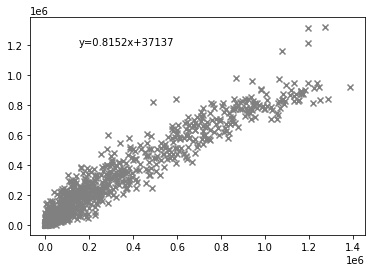

In [33]:
plt.scatter(X,Y,color='grey', marker='x', label='Data Points') 
plt.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))

[919805.146563845, 82.45184016344182]
[949499.8515932031, 312.13312587895234]
[243154.36355078197, 328545.8062548962]


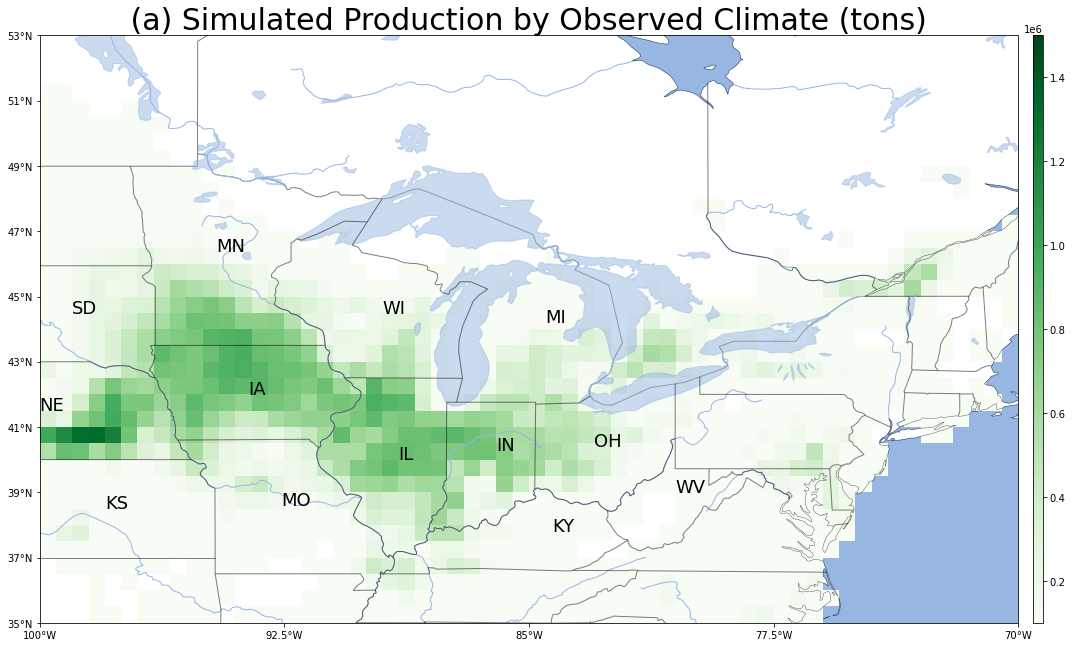

In [34]:
#Display data 
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt

provinces= ['Ontario', 'Quebec','Manitoba','Wisconsin','Vermont','Nebraska','New York','Kansas','Illinois',
            'Delaware','Connecticut','Indiana','Missouri','Michigan','New Jersey','Kentucky','Minnesota',
            'Ohio','Iowa','Pennsylvania','Maryland','Virginia','West Virginia','North Dakota','South Dakota','Nunavut']
provinces1=['ON','QC','MB','WI','VT','NE','NY','KS','IL','DE','CT','IN','MO','MI','NJ','KY','MN','OH','IA','PA','MD','VA','WV','ND','SD','NU']
Latitudes= [50,53,56.4,44.5,44,41.5,43,38.5,40,39,41.6,40.3,38.6,44.2,39.8,37.8,46.4,
            40.4,42,41.2,39,38,39,47.7,44.5,62]
Longitudes=[-85,-76,-98.7,-89.5,-72,-100,-75,-98,-89,-73.5,-72.7,-86,-92.6,-84.5,-74.9,-84.3,-94.6,
            -83,-93.6,-77.2,-76.6,-78,-80.5,-99,-99,-98]

mask=np.load('/media/Data1/Climada/isimip3/reference/isimip3b_mask60X60.npy')

lats = crop_isimip3a_mean.coords['lat'][:]
lons = crop_isimip3a_mean.coords['lon'][:]
X,Y = np.meshgrid(lons,lats)
projection = ccrs.PlateCarree()
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')
axes_class = (GeoAxes,
              dict(map_projection=projection))
# lons, lats = np.meshgrid(lons, lats)
title_text=["Refereance", "2050s", "2080s"]
fig = plt.figure(figsize=(15,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1%',
                label_mode='')  # note the empty labe
for i, ax in enumerate(axgr):
#*************************************************************
    if i==0:
        data=ensembleMean.squeeze()
        data=np.where(data == 0, np.nan, data)
        data=data*mask
        subtitle=" (a) Simulated Production by Observed Climate (tons) "
        print([np.nanpercentile(data,99.0),np.nanpercentile(data,0)])
        print([np.nanpercentile(data[37:56,:40],99.0),np.nanpercentile(data[37:56,:40],0)])
        print([np.nanpercentile(data[37:56,:40],50.0),np.nanmean(data[37:56,:40])])          
  
                     
#add ocean, coastline,borders,lakes,rivers,provinc_bodr
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(provinc_bodr, linestyle='-', linewidth=1, edgecolor="k", zorder=10, alpha=0.5)
    ax.set_title(subtitle, fontsize=30)
    ax.set_xlim([-100,-70])
    ax.set_ylim([35,53])
    ax.set_xticks(np.linspace(-100, -70, 5), crs=projection)
    ax.set_yticks(np.linspace(35, 53, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
#     p = ax.contourf(lons, lats, data,50,
#                         transform=projection,
#                         cmap='BrBG')
    
#     l = ax.contour(lons, lats, data,25,colors=['black'], linewidth=0.3,
#                         transform=ccrs.PlateCarree())
    for iprov in range(26):
        if Longitudes[iprov]<-80 and Latitudes[iprov]<47:
            ax.text(Longitudes[iprov],Latitudes[iprov],provinces1[iprov],fontsize=18)
#     p = ax.pcolormesh(X, Y, data,
#                       vmin=-300,
#                       vmax=300,
#                       transform=projection,
#                       cmap='Reds')
    p = ax.pcolormesh(X, Y, data,
                      transform=projection,
                      vmin=100000,
                      vmax=1500000,
                      cmap='Greens')    
#     ax.clabel(
#         l,  # Typically best results when labelling line contours.
#         colors=['black'],
#         manual=False,  # Automatic placement vs manual placement.
#         inline=True,  # Cut the line where the label will be placed.
#         fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
#     )
axgr.cbar_axes[0].colorbar(p)
plt.tight_layout()
plt.show()
fig.savefig('isimip3a_production_for_maize_20Years.png',dpi=150)

In [35]:
prod2000_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/prod2000_60x60.npy')
prod2005_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/prod2005_60x60.npy')
prod2010_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/prod2010_60x60.npy')

irrigated_maize_prod2000_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/irrigated_maize_prod2000_60x60.npy')
irrigated_maize_prod2005_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/irrigated_maize_prod2005_60x60.npy')
irrigated_maize_prod2010_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/irrigated_maize_prod2010_60x60.npy')

# convert nan to 0
prod2000_60x60=np.nan_to_num(prod2000_60x60)
prod2005_60x60=np.nan_to_num(prod2005_60x60)
prod2010_60x60=np.nan_to_num(prod2010_60x60)
irrigated_maize_prod2000_60x60[irrigated_maize_prod2000_60x60<0]=0
irrigated_maize_prod2005_60x60[irrigated_maize_prod2005_60x60<0]=0
irrigated_maize_prod2010_60x60[irrigated_maize_prod2010_60x60<0]=0
#important: without this step, all nan will transfer to all
irrigated_maize_prod2000_60x60=np.nan_to_num(irrigated_maize_prod2000_60x60)
irrigated_maize_prod2005_60x60=np.nan_to_num(irrigated_maize_prod2005_60x60)
irrigated_maize_prod2010_60x60=np.nan_to_num(irrigated_maize_prod2010_60x60)
# calculate 3-year averages
all_prod2000_60x60=prod2000_60x60+irrigated_maize_prod2000_60x60
all_prod2005_60x60=prod2005_60x60+irrigated_maize_prod2005_60x60
all_prod2010_60x60=prod2010_60x60+irrigated_maize_prod2010_60x60

/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_ldndc_gswp3-w5e5_default_annual_

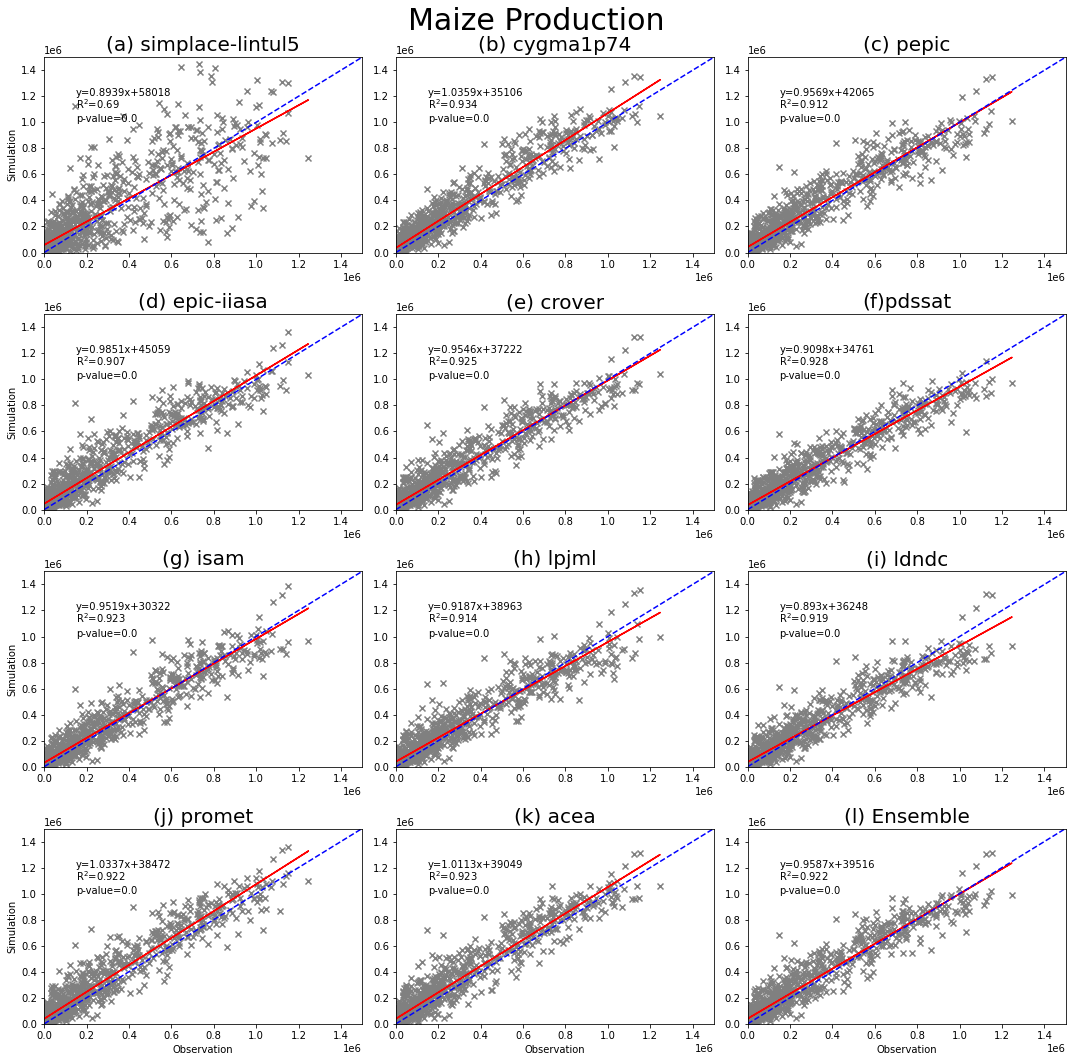

In [36]:
production_2000=np.empty(shape=(13,60,60)) # 1-11: 11 models; 12: ensemble mean;13:spam data
simulated_prod2000_60x60=np.full((60, 60, 12), np.nan) 
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
ii=0

for fn in fns:
    print(fn)
    ds=xr.open_dataset(fn,decode_times=False)
    #ds=xr.open_dataset(fn)
    #subtract data in space and time, fill nan with 0
    cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2000','2000'), irr=1.0).fillna(0)
    cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2000','2000'), irr=2.0).fillna(0)
  
    #average over years and sum over irrigated and rainfed
    crop_isimip3a1_mean=cropped_ds1.mean(dim='years')*rainfed_landuse/100
    crop_isimip3a2_mean=cropped_ds2.mean(dim='years')*irrigated_landuse/100
    crop_isimip3a_mean= crop_isimip3a1_mean+crop_isimip3a2_mean
#     #these data are change in % relative to average for the period of 1983 to 2013
#     averages1983_2013 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     #theoritically the average values for the reference periods are 100s at all grid points
#     averages1996_2015 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     averages2040_2069 = cropped_ds.sel(years=slice("2040", "2069")).mean(dim='years')+100
#     averages2070_2099 = cropped_ds.sel(years=slice("2070", "2099")).mean(dim='years')+100
#     averages2050s_ssp585=(averages2040_2069/averages1996_2015-1)*average_all
#     averages2080s_ssp585=(averages2070_2099/averages1996_2015-1)*average_all
    data=crop_isimip3a_mean['yield'].values.squeeze()*areainsqmeter/10000
    production_2000[ii,:,:]=data
    if ii==0:
        ensembleMean=data/11
    else:
        ensembleMean=ensembleMean+data/11
        
    simulated_prod2000_60x60[:,:,ii]=data
    X = all_prod2000_60x60.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan    
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)
    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()
    # Print the summary
    #print(results.summary())  

    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)

    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_ggcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
production_2000[11,:,:]=ensembleMean
production_2000[12,:,:]=all_prod2000_60x60
data=np.where(ensembleMean == 0, np.nan, ensembleMean)
#/spam_production
simulated_prod2000_60x60[:,:,11]=data
X = all_prod2000_60x60.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title(name_ggcms[ii], fontsize=20)
plt.tight_layout()
fig.savefig('isimip3a_production_observation_simulation_regression_for_maize_year2000.png',dpi=150)
np.save('isimip3a_production_2000.npy',production_2000)

In [37]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[240499091.77122638, 276763132.22566056, 36264040.454434186, 1.1507866004289538, 0.15078660042895375]


/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_ldndc_gswp3-w5e5_default_annual_

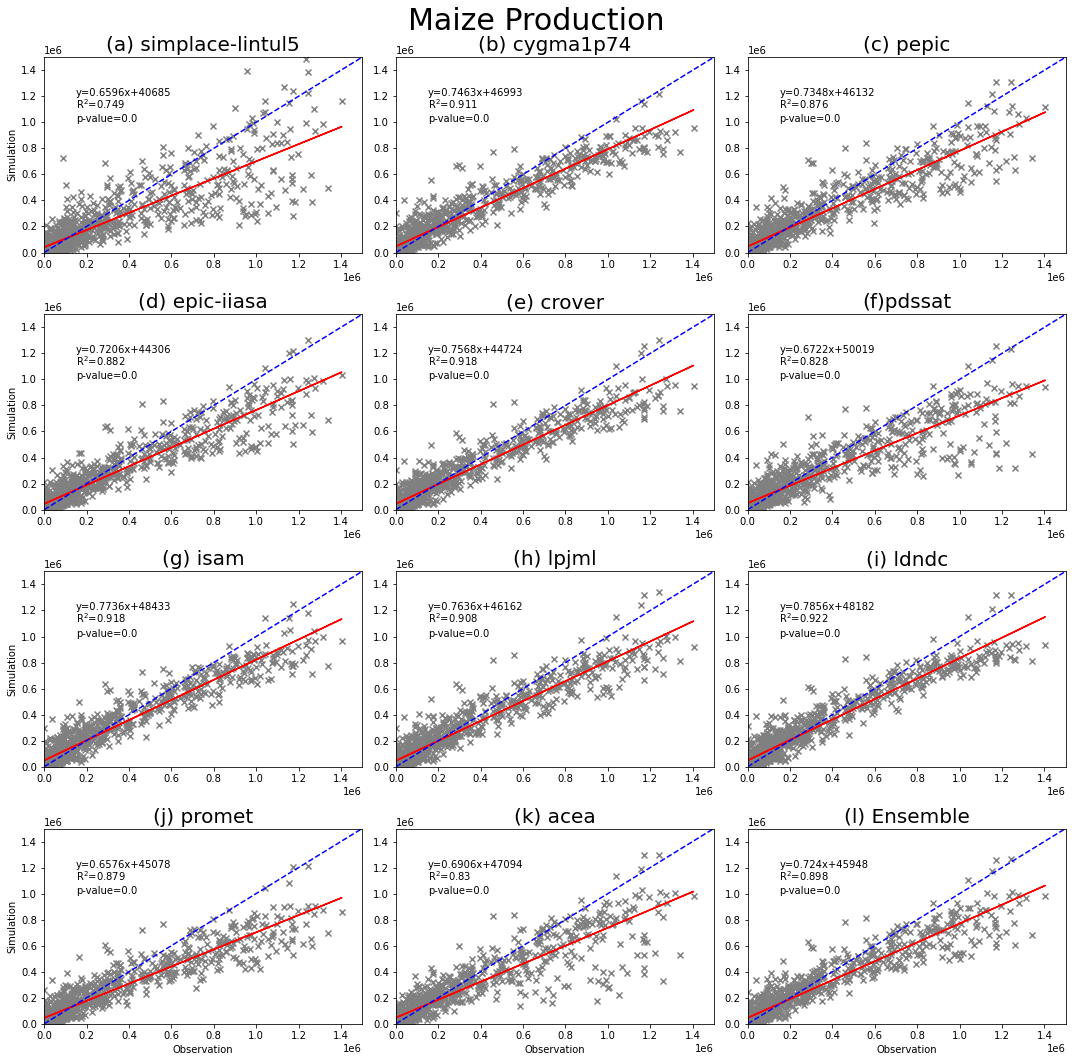

In [38]:
production_2005=np.empty(shape=(13,60,60)) # 1-11: 11 models; 12: ensemble mean;13:spam data
simulated_prod2005_60x60=np.full((60, 60, 12), np.nan) 
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
ii=0

for fn in fns:
    print(fn)
    ds=xr.open_dataset(fn,decode_times=False)
    #ds=xr.open_dataset(fn)
    #subtract data in space and time, fill nan with 0
    cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2005','2005'), irr=1.0).fillna(0)
    cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2005','2005'), irr=2.0).fillna(0)
  
    #average over years and sum over irrigated and rainfed
    crop_isimip3a1_mean=cropped_ds1.mean(dim='years')*rainfed_landuse/100
    crop_isimip3a2_mean=cropped_ds2.mean(dim='years')*irrigated_landuse/100
    crop_isimip3a_mean= crop_isimip3a1_mean+crop_isimip3a2_mean
#     #these data are change in % relative to average for the period of 1983 to 2013
#     averages1983_2013 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     #theoritically the average values for the reference periods are 100s at all grid points
#     averages1996_2015 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     averages2040_2069 = cropped_ds.sel(years=slice("2040", "2069")).mean(dim='years')+100
#     averages2070_2099 = cropped_ds.sel(years=slice("2070", "2099")).mean(dim='years')+100
#     averages2050s_ssp585=(averages2040_2069/averages1996_2015-1)*average_all
#     averages2080s_ssp585=(averages2070_2099/averages1996_2015-1)*average_all
    data=crop_isimip3a_mean['yield'].values.squeeze()*areainsqmeter/10000
    production_2005[ii,:,:]=data
    if ii==0:
        ensembleMean=data/11
    else:
        ensembleMean=ensembleMean+data/11
        
    simulated_prod2005_60x60[:,:,ii]=data
    X = all_prod2005_60x60.ravel()
    
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)
    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()
    # Print the summary
    #print(results.summary())  

    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)

    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_ggcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
data=np.where(ensembleMean == 0, np.nan, ensembleMean)
production_2005[11,:,:]=ensembleMean
production_2005[12,:,:]=all_prod2005_60x60
#/spam_production
simulated_prod2005_60x60[:,:,11]=data
X = all_prod2005_60x60.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]

# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title(name_ggcms[ii], fontsize=20)
plt.tight_layout()
fig.savefig('isimip3a_production_observation_simulation_regression_for_maize_year2005.png',dpi=150)
np.save('isimip3a_production_2005.npy',production_2005)

In [39]:
print([np.nanmean(X),np.nanmean(Y),np.nanmean(Y)-np.nanmean(X), np.nanmean(Y)/np.nanmean(X)])

[242626.478493022, 221606.55994217453, -21019.918550847477, 0.9133651088644391]


In [40]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[261308717.3369847, 238670265.05772197, -22638452.27926272, 0.9133651088644391, -0.08663489113556089]


/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_ldndc_gswp3-w5e5_default_annual_

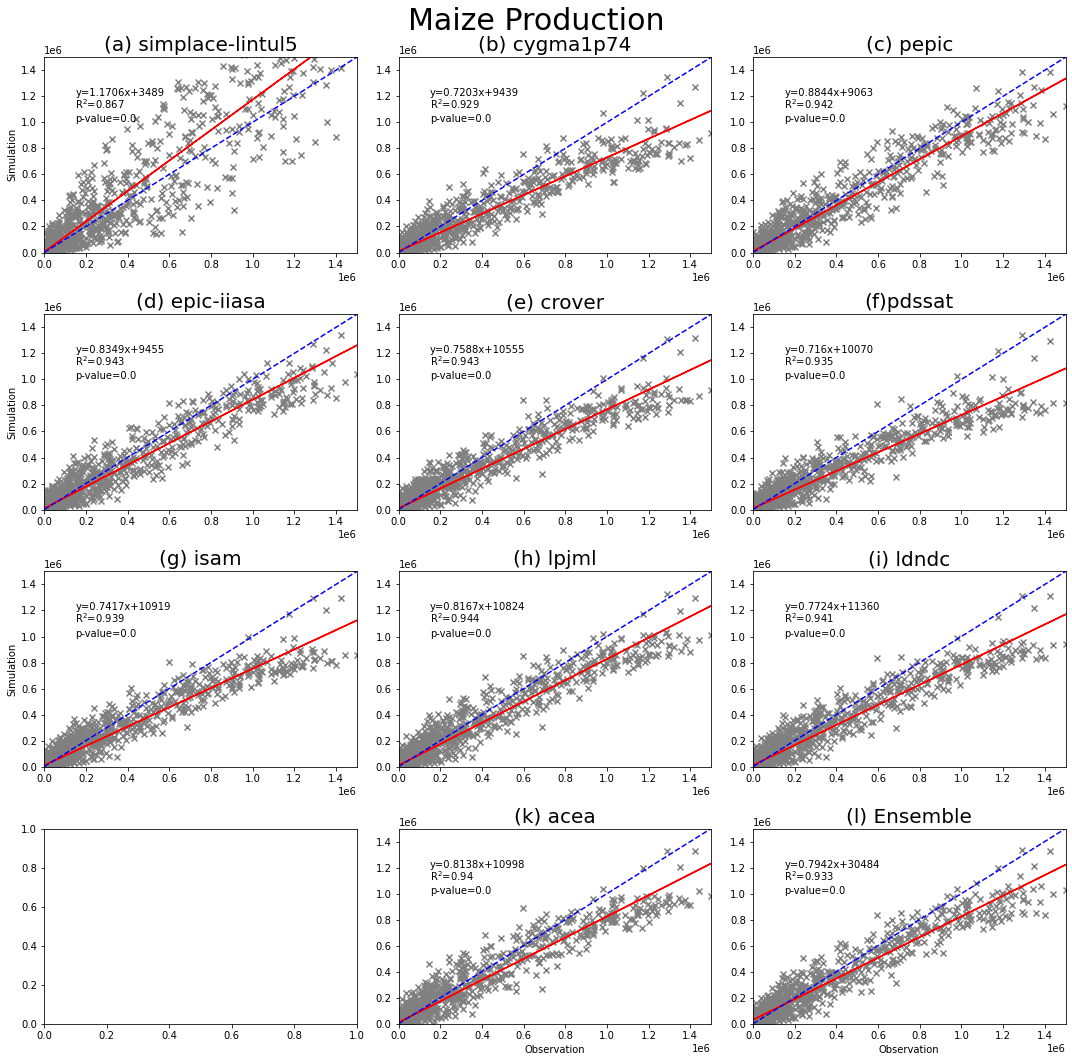

In [41]:
## 
production_2010=np.empty(shape=(13,60,60)) # 1-11: 11 models; 12: ensemble mean;13:spam data
simulated_prod2010_60x60=np.full((60, 60, 12), np.nan) 
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
ii=0
#below data has problem in 2010
prmetfirr='maize3a/promet_gswp3-w5e5_obsclim_2015soc_default_yield-mai-firr_global_annual-gs_1901_2015.nc'
prmetnoirr='maize3a/promet_gswp3-w5e5_obsclim_2015soc_default_yield-mai-noirr_global_annual-gs_1901_2015.nc'
#-----
for fn in fns:
    print(fn)
    ds=xr.open_dataset(fn,decode_times=False)
    #ds=xr.open_dataset(fn)
    #subtract data in space and time, fill nan with 0
    cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2010','2010'), irr=1.0).fillna(0)
    cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2010','2010'), irr=2.0).fillna(0)
    if 'promet' in fn:
        ds=xr.open_dataset(prmetnoirr,decode_times=False)
        cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(209,209)).fillna(0)
        ds=xr.open_dataset(prmetfirr,decode_times=False)
        
        cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(209,209)).fillna(0)        
    #average over years and sum over irrigated and rainfed
    if 'promet' in fn:
        crop_isimip3a1_mean=cropped_ds1.mean(dim='time')*rainfed_landuse/100
        crop_isimip3a2_mean=cropped_ds2.mean(dim='time')*irrigated_landuse/10000
        crop_isimip3a_mean= crop_isimip3a1_mean['yield-mai-noirr']+crop_isimip3a2_mean['yield-mai-firr']
    else:
        crop_isimip3a1_mean=cropped_ds1.mean(dim='years')*rainfed_landuse/100
        crop_isimip3a2_mean=cropped_ds2.mean(dim='years')*irrigated_landuse/100
        crop_isimip3a_mean= crop_isimip3a1_mean+crop_isimip3a2_mean
#     #these data are change in % relative to average for the period of 1983 to 2013
#     averages1983_2013 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     #theoritically the average values for the reference periods are 100s at all grid points
#     averages1996_2015 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     averages2040_2069 = cropped_ds.sel(years=slice("2040", "2069")).mean(dim='years')+100
#     averages2070_2099 = cropped_ds.sel(years=slice("2070", "2099")).mean(dim='years')+100
#     averages2050s_ssp585=(averages2040_2069/averages1996_2015-1)*average_all
#     averages2080s_ssp585=(averages2070_2099/averages1996_2015-1)*average_all
    if 'promet' in fn:
        data=crop_isimip3a_mean.values.squeeze()*areainsqmeter/10000    
    else:    
        data=crop_isimip3a_mean['yield'].values.squeeze()*areainsqmeter/10000
    if ii==0:
        ensembleMean=data/10
    else:
        if 'promet' in fn:
            ii=ii+1
            continue
        else:
            ensembleMean=ensembleMean+data/10
        
    simulated_prod2010_60x60[:,:,ii]=data
    production_2010[ii,:,:]=data
    X = all_prod2010_60x60.ravel()
    Y = data.ravel()
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)
    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()
    # Print the summary
    #print(results.summary())  

    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)

    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_ggcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
data=np.where(ensembleMean == 0, np.nan, ensembleMean)
production_2010[11,:,:]=ensembleMean
production_2010[12,:,:]=all_prod2010_60x60
#/spam_production
simulated_prod2010_60x60[:,:,11]=data
X = all_prod2010_60x60.ravel()
Y=data.ravel()
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]

# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title(name_ggcms[ii], fontsize=20)
plt.tight_layout()
fig.savefig('isimip3a_production_observation_simulation_regression_for_maize_year2010.png',dpi=150)
np.save('isimip3a_production_2010.npy',production_2010)

In [42]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[295107896.71184075, 271590365.4994757, -23517531.21236503, 0.9203087024291701, -0.07969129757082993]


In [43]:
### prepared data
d0500=simulated_prod2005_60x60-simulated_prod2000_60x60
d1005=simulated_prod2010_60x60-simulated_prod2005_60x60

od0500=prod2005_60x60-prod2000_60x60
od1005=prod2010_60x60-prod2005_60x60
XX=np.vstack((od1005,od0500))

In [44]:
np.nanmax(XX)

495895.5009994507

In [45]:
np.nanmax(d1005)

1841090.28683022

In [46]:
np.nanmax(d0500)

1009986.752126734